# Comparing Helsinki Neighbourhoods
We will explore the neighoubour hoods of my home city - Helsinki, Finland. This is somewhat like the analysis we did as practise for New Your and Toronto, but with some twist! In addition to venues from Foursquare, we will using some other, socio-economical indicators, namely:
* Occupational structure of each region (relative number of children / students / unemployed / working / pensioners...)
* Average household income

This information, as well as postal codes of Helsinki, are available as open data. 

I feel that adding socio-economical indicators - in addition to Foursquare venue data, that is, service offering of the area - will give a more complete picture of "nature" of each neighbourhood.

In [1]:
# Install and import required libraries, as in New Your/Toronto clustering notebook
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

!conda install -c conda-forge geopy --yes
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

!conda install -c conda-forge folium=0.5.0 --yes 
import folium # map rendering library

!conda install -c conda-forge beautifulsoup4 --yes 
from bs4 import BeautifulSoup

!conda install -c conda-forge geocoder --yes 
import geocoder

!conda install -c conda-forge pyproj
import pyproj

Solving environment: ...working... done

## Package Plan ##

  environment location: C:\Users\rikus\anaconda3

  added / updated specs:
    - geopy


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    geographiclib-1.52         |     pyhd8ed1ab_0          35 KB  conda-forge
    geopy-2.2.0                |     pyhd8ed1ab_0          67 KB  conda-forge
    ------------------------------------------------------------
                                           Total:         102 KB

The following NEW packages will be INSTALLED:

  geographiclib      conda-forge/noarch::geographiclib-1.52-pyhd8ed1ab_0
  geopy              conda-forge/noarch::geopy-2.2.0-pyhd8ed1ab_0
  python_abi         conda-forge/win-64::python_abi-3.9-2_cp39

The following packages will be SUPERSEDED by a higher-priority channel:

  conda              pkgs/main::conda-4.11.0-py39haa95532_0 --> conda-forge::conda-4.11.0-py39hc

ModuleNotFoundError: No module named 'pyproj'

## Postal codes and neighbourhood names of Helsinki
Helsinki Postal code data is available for feree from Helsinki Region Infoshare, see: https://hri.fi/data/en_GB/dataset/paakaupunkiseudun-postinumeroalueet

No API keys or such are needesd. Data is in JSON format, and needs to be parsed a little.

In [12]:
from xml.dom import minidom
from urllib.request import Request, urlopen

#urlPostalCodes = 'https://hri.fi/data/api/action/datastore_search?resource_id=cbc11e4a-f695-4efa-93d7-9446066a07dd&limit=84'
#results = requests.get(urlPostalCodes).json()['result']['records']
urlXmlPostalCodes = 'https://avoidatastr.blob.core.windows.net/avoindata/AvoinData/9_Kartat/PKS%20postinumeroalueet/Kml/PKS_postinumeroalueet_2021.kml'
req = Request(urlXmlPostalCodes)
r = urlopen(req)
rString = r.read().decode("utf-8")

parsedXml = minidom.parseString(rString)
places = parsedXml.getElementsByTagName('Placemark')
postal_code_list=[]
for place in places:
    datapoints = place.getElementsByTagName('SimpleData')
    for datapoint in datapoints:
        if datapoint.getAttribute('name') == "Postinumero":
            postinumero = datapoint.firstChild.data
        if datapoint.getAttribute('name') == "Nimi":
            postinumeroNimi = datapoint.firstChild.data
    postal_code_list.append((
            postinumero,
            postinumeroNimi))
postal_codes = pd.DataFrame.from_records(postal_code_list, columns=['PostalCode', 'NeighbourhoodName'], index='PostalCode')
postal_codes.sort_index(inplace=True)
postal_codes.head()

NeighbourhoodName
PostalCode                               
00100       Helsinki Keskusta - Etu-Töölö
00120                           Punavuori
00130                     Kaartinkaupunki
00140            Kaivopuisto - Ullanlinna
00150                   Eira - Hernesaari

## Occupation data for Helsinki region
Occupational data by postal code - and a wealth of other pieces of data - is available for free from Statistics Finland.

The data can also be browsed via a web interface in here:<br/>
http://pxnet2.stat.fi/PXWeb/pxweb/en/Postinumeroalueittainen_avoin_tieto/Postinumeroalueittainen_avoin_tieto__2018/paavo_8_pt_2018.px/?rxid=39840011-c10c-4e00-8cd1-7015d2e09479.

The data received is in JSON "list format", that is, not grouped by postal code. We need to do some pivoting, as well as some further handling, to make the data usable. We need to have the relative share of various groups. The division used is the Finnish "standard division of labour", which is the following:
* Children (aged 0-14)
* Students
* Unemployed
* Workforce (which contains both employed and unemployed)
* Other (this means for example housewives)
* Pensioners

We want to separate between employed and unemployed, so we calculate employed=workforce-unemployed.

In [53]:
import requests
# Occupation data by postal code from Statistics Finland web service

# Define a function for this purpose
def fetchDataFromStatFinland(url, postalCodeList, dataItemList):
    postData={
      "query": [
        {
          "code": "Postinumeroalue",
          "selection": {
            "filter": "item",
            "values": postalCodeList

          }
        }
      ],
      "response": {
        "format": "json"
      }
    }
    results=requests.post(url, json=postData).json()['data']
    data_list = []
    for row in results:
        data_list.append((
            row['key'][0],
            row['values'][0],
            row['values'][1],
            row['values'][2],
            row['values'][3],
            row['values'][4],
            row['values'][5],
            row['values'][6]
        ))
    return data_list
    
# These are the data items we need
urlOccupationData = 'https://pxnet2.stat.fi:443/PXWeb/api/v1/en/Postinumeroalueittainen_avoin_tieto/2021/paavo_pxt_12f6.px'
occupationDataItems = ["pt_vakiy", "pt_tyoll","pt_tyott","pt_0_14","pt_opisk","pt_elakel","pt_muut"]
occupation_data_list = fetchDataFromStatFinland(urlOccupationData, postal_codes.index.values.tolist(), occupationDataItems) 

columnNames=['Total', 'Workforce', 'Unemployed','Child','Student','Pensioner','Others']
occupation_data = pd.DataFrame.from_records(occupation_data_list, columns=['PostalCode']+columnNames, index='PostalCode')
# The data read has strangerly '...' to mark zero value!
occupation_data = occupation_data.replace('...','0')
# Now calculate the relative share of different occupations - noting what we are told workforce and unemployed - we have to calculate the relative share of working people
occupation_data[columnNames] = occupation_data[columnNames].apply(pd.to_numeric)
occupation_data['EmployedR'] = occupation_data['Workforce'] / occupation_data['Total']
occupation_data['UnemployedR'] = occupation_data['Unemployed']  / occupation_data['Total']
occupation_data['ChildR'] = occupation_data['Child']  / occupation_data['Total']
occupation_data['StudentR'] = occupation_data['Student']  / occupation_data['Total']
occupation_data['OthersR'] = occupation_data['Others']  / occupation_data['Total']
occupation_data['PensionerR'] = occupation_data['Pensioner']  / occupation_data['Total']
occupation_data.drop(columnNames, inplace=True, axis=1)
occupation_data.head()

EmployedR  UnemployedR    ChildR  StudentR   OthersR  PensionerR
PostalCode                                                                  
00100        0.573940     0.032941  0.100179  0.066587  0.040755    0.185597
00120        0.569892     0.033655  0.115766  0.058511  0.048597    0.173579
00130        0.575181     0.024294  0.112935  0.056467  0.056467    0.174655
00140        0.536675     0.032950  0.124479  0.057947  0.054791    0.193157
00150        0.587533     0.038785  0.101971  0.056153  0.051039    0.164518

In [54]:
# Now, merge this with post number data
helsinki_data = pd.concat([postal_codes, occupation_data], axis=1)
helsinki_data.head()

NeighbourhoodName  EmployedR  UnemployedR    ChildR  \
PostalCode                                                                    
00100       Helsinki Keskusta - Etu-Töölö   0.573940     0.032941  0.100179   
00120                           Punavuori   0.569892     0.033655  0.115766   
00130                     Kaartinkaupunki   0.575181     0.024294  0.112935   
00140            Kaivopuisto - Ullanlinna   0.536675     0.032950  0.124479   
00150                   Eira - Hernesaari   0.587533     0.038785  0.101971   

            StudentR   OthersR  PensionerR  
PostalCode                                  
00100       0.066587  0.040755    0.185597  
00120       0.058511  0.048597    0.173579  
00130       0.056467  0.056467    0.174655  
00140       0.057947  0.054791    0.193157  
00150       0.056153  0.051039    0.164518

## Median household income for Helsinki region  
This we can also fetch from Statistics Finland, from a different data set:<br>
http://pxnet2.stat.fi/PXWeb/pxweb/en/Postinumeroalueittainen_avoin_tieto/Postinumeroalueittainen_avoin_tieto__2018/paavo_5_tr_2018.px/?rxid=39840011-c10c-4e00-8cd1-7015d2e09479

Data handling is analogous to data handling of the occupational data.

In [61]:
# Next, get median income per household per postal code area, from Statistics Finland
urlIncomeData = 'http://pxnet2.stat.fi/PXWeb/api/v1/en/Postinumeroalueittainen_avoin_tieto/2018/paavo_5_tr_2018.px'
incomeDataList = ['Tr_mtu']
income_data_list = fetchDataFromStatFinland(urlIncomeData, postal_codes.index.values.tolist(), incomeDataList) 
income_data = pd.DataFrame.from_records(income_data_list[0], columns=['PostalCode', 'IncomeCategory', 'MedianHouseholdIncome'])

income_data_pivoted = income_data.pivot(index='PostalCode', columns='IncomeCategory', values='MedianHouseholdIncome')
# Translate the column names
income_data_pivoted.rename(columns={'Tr_mtu':'MedianHouseholdIncome'}, inplace=True)
income_data_pivoted = income_data_pivoted.replace('.','0')
columnNames = ['MedianHouseholdIncome']
# Now normalize the income
income_data_pivoted[columnNames] = income_data_pivoted[columnNames].apply(pd.to_numeric)
#Standard scaled 
income_data_pivoted['MedianHouseholdIncomeNorm'] = \
    (income_data_pivoted['MedianHouseholdIncome']-income_data_pivoted['MedianHouseholdIncome'].mean())/ \
    income_data_pivoted['MedianHouseholdIncome'].std()
#Min-max scaled
#income_data_pivoted['MedianHouseholdIncomeNorm'] = \
#    (income_data_pivoted['MedianHouseholdIncome']-income_data_pivoted['MedianHouseholdIncome'].min()) / \
#    (income_data_pivoted['MedianHouseholdIncome'].max() - income_data_pivoted['MedianHouseholdIncome'].min())
income_data_pivoted.drop(columnNames, inplace=True, axis=1)
income_data_pivoted.head()

IncomeCategory  MedianHouseholdIncomeNorm
PostalCode                               
00100                            0.135282
00120                            0.311709
00130                            0.701486
00140                            0.397746
00150                           -0.284276

In [62]:
# Merge this, too with the existing dataset
helsinki_data = pd.concat([helsinki_data, income_data_pivoted], axis=1)
helsinki_data.head()

NeighbourhoodName  EmployedR  UnemployedR    ChildR  \
PostalCode                                                                    
00100       Helsinki Keskusta - Etu-Töölö   0.552440     0.048355  0.099228   
00120                           Punavuori   0.546114     0.049815  0.113009   
00130                     Kaartinkaupunki   0.561198     0.045573  0.110677   
00140            Kaivopuisto - Ullanlinna   0.525905     0.048996  0.114110   
00150                   Eira - Hernesaari   0.569631     0.057641  0.098075   

            StudentR   OthersR  PensionerR  MedianHouseholdIncomeNorm  
PostalCode                                                             
00100       0.070405  0.045165    0.184408                   0.135282  
00120       0.061771  0.051950    0.177341                   0.311709  
00130       0.072266  0.046224    0.164062                   0.701486  
00140       0.064987  0.054880    0.191122                   0.397746  
00150       0.060652  0.054414    0.159587                  -0.284276

## Housing type and average size per neighborhood
We use the same style as above, but this time we'll fetch some housing type (apartment/house) and average apartment/house size. I believe this differentiates neighborhoods pretty much.

In [63]:
# Next, get median income per household per postal code area, from Statistics Finland
urlHousingData = 'http://pxnet2.stat.fi/PXWeb/api/v1/en/Postinumeroalueittainen_avoin_tieto/2018/paavo_6_ra_2018.px'
housingDataList = ['Ra_as_kpa','Ra_pt_as','Ra_kt_as']
housing_data_list = fetchDataFromStatFinland(urlHousingData, postal_codes.index.values.tolist(), housingDataList) 
housing_data = pd.DataFrame.from_records(housing_data_list[0], columns=['PostalCode', 'DataKey', 'DataValue'])

housing_data_pivoted = housing_data.pivot(index='PostalCode', columns='DataKey', values='DataValue')
# Translate the column names
housing_data_pivoted.rename(columns={'Ra_as_kpa':'AverageFloorSize','Ra_pt_as':'DwellingsHouse','Ra_kt_as':'DwellingsApartment'}, inplace=True)
housing_data_pivoted = housing_data_pivoted.replace('.','0')
columnNames = ['AverageFloorSize','DwellingsHouse','DwellingsApartment']
housing_data_pivoted[columnNames] = housing_data_pivoted[columnNames].apply(pd.to_numeric)
# Normalize average housing size & relative shares of house / apartment dwellings
housing_data_pivoted['AverageFloorSizeR'] = \
    (housing_data_pivoted['AverageFloorSize']-housing_data_pivoted['AverageFloorSize'].min()) / \
    (housing_data_pivoted['AverageFloorSize'].max() - housing_data_pivoted['AverageFloorSize'].min())
housing_data_pivoted['DwellingsHouseR'] = \
    housing_data_pivoted['DwellingsHouse']/(housing_data_pivoted['DwellingsHouse']+housing_data_pivoted['DwellingsApartment'])
housing_data_pivoted['DwellingsApartmentR'] = \
    housing_data_pivoted['DwellingsApartment']/(housing_data_pivoted['DwellingsHouse']+housing_data_pivoted['DwellingsApartment'])
housing_data_pivoted.drop(columnNames, inplace=True, axis=1)
housing_data_pivoted.head()

DataKey     AverageFloorSizeR  DwellingsHouseR  DwellingsApartmentR
PostalCode                                                         
00100                0.408390         0.000170             0.999830
00120                0.426897         0.001583             0.998417
00130                0.462060         0.000000             1.000000
00140                0.455891         0.002580             0.997420
00150                0.342998         0.004730             0.995270

In [64]:
# Merge this, too with the existing dataset
helsinki_data = pd.concat([helsinki_data, housing_data_pivoted], axis=1)
helsinki_data.head()

NeighbourhoodName  EmployedR  UnemployedR    ChildR  \
PostalCode                                                                    
00100       Helsinki Keskusta - Etu-Töölö   0.552440     0.048355  0.099228   
00120                           Punavuori   0.546114     0.049815  0.113009   
00130                     Kaartinkaupunki   0.561198     0.045573  0.110677   
00140            Kaivopuisto - Ullanlinna   0.525905     0.048996  0.114110   
00150                   Eira - Hernesaari   0.569631     0.057641  0.098075   

            StudentR   OthersR  PensionerR  MedianHouseholdIncomeNorm  \
PostalCode                                                              
00100       0.070405  0.045165    0.184408                   0.135282   
00120       0.061771  0.051950    0.177341                   0.311709   
00130       0.072266  0.046224    0.164062                   0.701486   
00140       0.064987  0.054880    0.191122                   0.397746   
00150       0.060652  0.054414    0.159587                  -0.284276   

            AverageFloorSizeR  DwellingsHouseR  DwellingsApartmentR  
PostalCode                                                           
00100                0.408390         0.000170             0.999830  
00120                0.426897         0.001583             0.998417  
00130                0.462060         0.000000             1.000000  
00140                0.455891         0.002580             0.997420  
00150                0.342998         0.004730             0.995270

## Coordinates of neighbourhoods
Now we proceed in the same way as we did with Toronto - we fetch coordinates of each postal code by Bing geocoding. That seems to work quite reliably.

In [10]:
# The code was removed by Watson Studio for sharing.

In [65]:
# A function to return lat and long given postal code
def fetchCoordinatesByAddress(address):
    coords = None
    n_times = 0
    while((coords is None) & (n_times < 5)):
        print('Trying to find {} from Bing'.format(address))
        g = geocoder.bing(address, key=BING_KEY)
        coords = g.latlng
        n_times = n_times + 1
    if coords != None:
        return coords[0], coords[1]
    else:
        # Open Street Map address not found, let us try Bing instead
        print('Trying to find {} from Open Street Map'.format(address))
        g = geocoder.osm(address)
        coords = g.osm
        if coords != None:
            return coords['y'], coords['x']
        else:
            return 0.0, 0.0

# Loop through all areas and fetch coordinates by postal code
lats=[]
longs=[]
for index, area in postal_codes.iterrows():
    lat, lon = fetchCoordinatesByAddress('{}, Helsinki, Finland'.format(index))
    lats.append(lat)
    longs.append(lon)
helsinki_data = helsinki_data.assign(Latitude=lats, Longitude=longs)
helsinki_data.head()

Trying to find 00100, Helsinki, Finland from Bing
Trying to find 00120, Helsinki, Finland from Bing
Trying to find 00130, Helsinki, Finland from Bing
Trying to find 00140, Helsinki, Finland from Bing
Trying to find 00150, Helsinki, Finland from Bing
Trying to find 00160, Helsinki, Finland from Bing
Trying to find 00170, Helsinki, Finland from Bing
Trying to find 00180, Helsinki, Finland from Bing
Trying to find 00190, Helsinki, Finland from Bing
Trying to find 00200, Helsinki, Finland from Bing
Trying to find 00210, Helsinki, Finland from Bing
Trying to find 00220, Helsinki, Finland from Bing
Trying to find 00230, Helsinki, Finland from Bing
Trying to find 00240, Helsinki, Finland from Bing
Trying to find 00250, Helsinki, Finland from Bing
Trying to find 00260, Helsinki, Finland from Bing
Trying to find 00270, Helsinki, Finland from Bing
Trying to find 00280, Helsinki, Finland from Bing
Trying to find 00290, Helsinki, Finland from Bing
Trying to find 00300, Helsinki, Finland from Bing


NeighbourhoodName  EmployedR  UnemployedR    ChildR  \
PostalCode                                                                    
00100       Helsinki Keskusta - Etu-Töölö   0.552440     0.048355  0.099228   
00120                           Punavuori   0.546114     0.049815  0.113009   
00130                     Kaartinkaupunki   0.561198     0.045573  0.110677   
00140            Kaivopuisto - Ullanlinna   0.525905     0.048996  0.114110   
00150                   Eira - Hernesaari   0.569631     0.057641  0.098075   

            StudentR   OthersR  PensionerR  MedianHouseholdIncomeNorm  \
PostalCode                                                              
00100       0.070405  0.045165    0.184408                   0.135282   
00120       0.061771  0.051950    0.177341                   0.311709   
00130       0.072266  0.046224    0.164062                   0.701486   
00140       0.064987  0.054880    0.191122                   0.397746   
00150       0.060652  0.054414    0.159587                  -0.284276   

            AverageFloorSizeR  DwellingsHouseR  DwellingsApartmentR  \
PostalCode                                                            
00100                0.408390         0.000170             0.999830   
00120                0.426897         0.001583             0.998417   
00130                0.462060         0.000000             1.000000   
00140                0.455891         0.002580             0.997420   
00150                0.342998         0.004730             0.995270   

             Latitude  Longitude  
PostalCode                        
00100       60.172020  24.925289  
00120       60.164116  24.939407  
00130       60.164246  24.949619  
00140       60.157925  24.953203  
00150       60.153954  24.929998

## Put the Helsinki Neighbourhoods on the map
We'll make a Folium map showing all the neighbourhoods on the map.

In [66]:
# We first need the address of Helsinki, Finland

helsinkiLat, helsinkiLon = fetchCoordinatesByAddress('Helsinki, Finland')
map_helsinki = folium.Map(location=[helsinkiLat, helsinkiLon], zoom_start=11)

# add markers to map
for lat, lng, postalCode, label in zip(helsinki_data['Latitude'], helsinki_data['Longitude'], helsinki_data.index, helsinki_data['NeighbourhoodName']):
    label = folium.Popup(postalCode + " " + label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_helsinki)  
    
map_helsinki

Trying to find Helsinki, Finland from Bing


## Folium picture generated for offline use
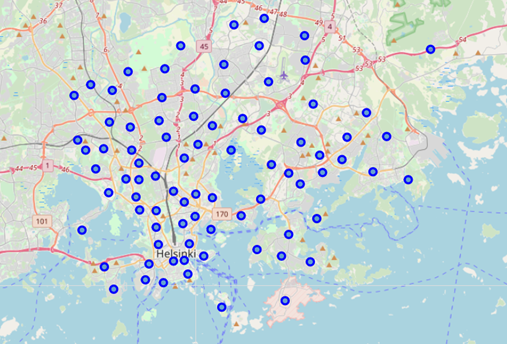


## Neighbourhood venues from Foursquare
This we do just as we did for New York and Toronto.

In [69]:
VERSION = '20180605' # Foursquare API version
LIMIT=100

# This is copied from the New York lab
def getNearbyVenues(postalCodes, names, latitudes, longitudes, radius=500):
    venues_list=[]
    for postalCode, name, lat, lng in zip(postalCodes, names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            FOURSQUARE_CLIENT_ID, 
            FOURSQUARE_CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
        #print(url)    
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            postalCode,
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['PostalCode',
                  'NeighbourhoodName', 
                  'Neighbourhood Latitude', 
                  'Neighbourhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

helsinki_venues = getNearbyVenues(helsinki_data.index, helsinki_data['NeighbourhoodName'], helsinki_data['Latitude'], helsinki_data['Longitude'])
helsinki_venues.head()

Helsinki Keskusta - Etu-Töölö
Punavuori
Kaartinkaupunki
Kaivopuisto - Ullanlinna
Eira - Hernesaari
Katajanokka
Kruununhaka
Kamppi - Ruoholahti
Suomenlinna
Lauttasaari
Vattuniemi
Jätkäsaari
Ilmala
Länsi-Pasila
Taka-Töölö
Keski-Töölö
Pohjois-Meilahti
Ruskeasuo
Meilahden sairaala-alue
Pikku Huopalahti
Kivihaka
Etelä-Haaga
Munkkiniemi
Kuusisaari-Lehtisaari
Munkkivuori-Niemenmäki
Pajamäki
Reimarla
Pitäjänmäen teollisuusalue
Konala
Pohjois-Haaga
Malminkartano
Kannelmäki
Maununneva
Lassila
Sörnäinen
Etu-Vallila - Alppila
Itä-Pasila
Kallio
Kalasatama
Vallila
Toukola-Vanhakaupunki
Kulosaari
Verkkosaari
Kaitalahti
Koskela-Helsinki
Käpylä
Metsälä-Etelä-Oulunkylä
Maunula-Suursuo
Oulunkylä-Patola
Veräjämäki
Länsi-Pakila
Paloheinä
Itä-Pakila
Tuomarinkylä-Torpparinmäki
Malmi
Pihlajamäki
Pukinmäki-Savela
Tapanila
Siltamäki
Puistola
Suurmetsä
Jakomäki - Alppikylä
Tapaninvainio
Viikki
Länsi-Herttoniemi
Herttoniemi
Roihuvuori
Tammisalo
Laajasalo
Jollas
Santahamina
Etelä-Laajasalo
Roihupellon teollisuusal

PostalCode              NeighbourhoodName  Neighbourhood Latitude  \
0      00100  Helsinki Keskusta - Etu-Töölö                60.17202   
1      00100  Helsinki Keskusta - Etu-Töölö                60.17202   
2      00100  Helsinki Keskusta - Etu-Töölö                60.17202   
3      00100  Helsinki Keskusta - Etu-Töölö                60.17202   
4      00100  Helsinki Keskusta - Etu-Töölö                60.17202   

   Neighbourhood Longitude                   Venue  Venue Latitude  \
0                24.925289               Cafetoria       60.173203   
1                24.925289            Ateljé Finne       60.171198   
2                24.925289  Twisted Street Kitchen       60.170641   
3                24.925289                 Hoshito       60.171347   
4                24.925289           Temppeliaukio       60.172552   

   Venue Longitude           Venue Category  
0        24.923024              Coffee Shop  
1        24.928515  Scandinavian Restaurant  
2        24.928203         Asian Restaurant  
3        24.926682      Japanese Restaurant  
4        24.925600                    Plaza

In [70]:
helsinki_venues.shape

(1518, 8)

In [71]:
# See number of venues by neighbourhood
helsinki_venues.groupby('PostalCode').count()

NeighbourhoodName  Neighbourhood Latitude  \
PostalCode                                              
00100                      40                      40   
00120                     100                     100   
00130                      91                      91   
00140                      50                      50   
00150                      11                      11   
00160                      31                      31   
00170                      90                      90   
00180                      30                      30   
00190                      21                      21   
00200                      27                      27   
00210                      24                      24   
00220                      16                      16   
00230                       3                       3   
00240                      20                      20   
00250                      39                      39   
00260                      73                      73   
00270                      20                      20   
00280                       8                       8   
00290                      20                      20   
00300                       8                       8   
00310                       6                       6   
00320                      10                      10   
00330                      19                      19   
00340                       7                       7   
00350                       5                       5   
00360                       6                       6   
00370                      15                      15   
00380                      12                      12   
00390                      23                      23   
00400                      10                      10   
00410                       5                       5   
00420                       5                       5   
00430                       3                       3   
00440                      11                      11   
00500                      58                      58   
00510                      27                      27   
00520                      31                      31   
00530                      82                      82   
00540                      10                      10   
00550                      36                      36   
00560                       7                       7   
00570                      12                      12   
00580                      13                      13   
00590                       4                       4   
00600                      11                      11   
00610                      14                      14   
00620                       6                       6   
00630                      16                      16   
00640                      25                      25   
00650                       5                       5   
00660                       8                       8   
00670                       5                       5   
00680                       8                       8   
00690                       3                       3   
00700                       4                       4   
00710                      12                      12   
00720                      19                      19   
00730                      10                      10   
00740                      11                      11   
00750                       4                       4   
00760                       7                       7   
00770                       4                       4   
00780                       5                       5   
00790                      10                      10   
00800                       2                       2   
00810                      24                      24   
00820                      14                      14   
00830                       2                       2   
00840                 

In [72]:
# See how many neighbourhoods got venues
helsinki_venues.groupby('PostalCode').count().shape

(83, 7)

In [73]:
helsinki_data.shape

(84, 13)

In [74]:
# Oh well, we have a problem, since not all of the postal have venues - luckily only one. Let us remove it from helsinki_data so we can combine info later
helsinki_venues.groupby('PostalCode').count().index.values

array(['00100', '00120', '00130', '00140', '00150', '00160', '00170',
       '00180', '00190', '00200', '00210', '00220', '00230', '00240',
       '00250', '00260', '00270', '00280', '00290', '00300', '00310',
       '00320', '00330', '00340', '00350', '00360', '00370', '00380',
       '00390', '00400', '00410', '00420', '00430', '00440', '00500',
       '00510', '00520', '00530', '00540', '00550', '00560', '00570',
       '00580', '00590', '00600', '00610', '00620', '00630', '00640',
       '00650', '00660', '00670', '00680', '00690', '00700', '00710',
       '00720', '00730', '00740', '00750', '00760', '00770', '00780',
       '00790', '00800', '00810', '00820', '00830', '00840', '00850',
       '00860', '00870', '00880', '00900', '00910', '00920', '00930',
       '00940', '00950', '00960', '00970', '00980', '00990'], dtype=object)

In [75]:
helsinki_data.index.values

array(['00100', '00120', '00130', '00140', '00150', '00160', '00170',
       '00180', '00190', '00200', '00210', '00220', '00230', '00240',
       '00250', '00260', '00270', '00280', '00290', '00300', '00310',
       '00320', '00330', '00340', '00350', '00360', '00370', '00380',
       '00390', '00400', '00410', '00420', '00430', '00440', '00500',
       '00510', '00520', '00530', '00540', '00550', '00560', '00570',
       '00580', '00590', '00600', '00610', '00620', '00630', '00640',
       '00650', '00660', '00670', '00680', '00690', '00700', '00710',
       '00720', '00730', '00740', '00750', '00760', '00770', '00780',
       '00790', '00800', '00810', '00820', '00830', '00840', '00850',
       '00860', '00870', '00880', '00890', '00900', '00910', '00920',
       '00930', '00940', '00950', '00960', '00970', '00980', '00990'], dtype=object)

In [76]:
# We can see that postal code 00890 in helsinki_data has no values. We'll delete it to stay away from harm. Sorry, 00890.
helsinki_data.drop('00890', inplace=True)
helsinki_data.index.values

array(['00100', '00120', '00130', '00140', '00150', '00160', '00170',
       '00180', '00190', '00200', '00210', '00220', '00230', '00240',
       '00250', '00260', '00270', '00280', '00290', '00300', '00310',
       '00320', '00330', '00340', '00350', '00360', '00370', '00380',
       '00390', '00400', '00410', '00420', '00430', '00440', '00500',
       '00510', '00520', '00530', '00540', '00550', '00560', '00570',
       '00580', '00590', '00600', '00610', '00620', '00630', '00640',
       '00650', '00660', '00670', '00680', '00690', '00700', '00710',
       '00720', '00730', '00740', '00750', '00760', '00770', '00780',
       '00790', '00800', '00810', '00820', '00830', '00840', '00850',
       '00860', '00870', '00880', '00900', '00910', '00920', '00930',
       '00940', '00950', '00960', '00970', '00980', '00990'], dtype=object)

## Reshape venue data according to venue type & analyze
Next we'll see what types of venues are most typical in each area. To do this, we one-hot encode the venues.

In [77]:
# One-hot encoding of the venues
helsinki_onehot = pd.get_dummies(helsinki_venues[['Venue Category']], prefix="", prefix_sep="")

helsinki_onehot['PostalCode'] = helsinki_venues['PostalCode']

# move neighborhood column to the first column
fixed_columns = [helsinki_onehot.columns[-1]] + list(helsinki_onehot.columns[:-1])
helsinki_onehot = helsinki_onehot[fixed_columns]

helsinki_onehot.head()

PostalCode  ATM  American Restaurant  Antique Shop  Art Gallery  Art Museum  \
0      00100    0                    0             0            0           0   
1      00100    0                    0             0            0           0   
2      00100    0                    0             0            0           0   
3      00100    0                    0             0            0           0   
4      00100    0                    0             0            0           0   

   Arts & Crafts Store  Asian Restaurant  Auditorium  Auto Workshop  \
0                    0                 0           0              0   
1                    0                 0           0              0   
2                    0                 1           0              0   
3                    0                 0           0              0   
4                    0                 0           0              0   

   Automotive Shop  BBQ Joint  Badminton Court  Bagel Shop  Bakery  Bar  \
0                0          0                0           0       0    0   
1                0          0                0           0       0    0   
2                0          0                0           0       0    0   
3                0          0                0           0       0    0   
4                0          0                0           0       0    0   

   Basketball Court  Bay  Beach  Beer Bar  Beer Garden  Bike Shop  Bistro  \
0                 0    0      0         0            0          0       0   
1                 0    0      0         0            0          0       0   
2                 0    0      0         0            0          0       0   
3                 0    0      0         0            0          0       0   
4                 0    0      0         0            0          0       0   

   Boat or Ferry  Bookstore  Boutique  Bowling Alley  Brazilian Restaurant  \
0              0          0         0              0                     0   
1              0          0         0              0                     0   
2              0          0         0              0                     0   
3              0          0         0              0                     0   
4              0          0         0              0                     0   

   Breakfast Spot  Brewery  Bridge  Buffet  Burger Joint  Burrito Place  \
0               0        0       0       0             0              0   
1               0        0       0       0             0              0   
2               0        0       0       0             0              0   
3               0        0       0       0             0              0   
4               0        0       0       0             0              0   

   Bus Line  Bus Stop  Cafeteria  Café  Campground  Canal  Candy Store  \
0         0         0          0     0           0      0            0   
1         0         0          0     0           0      0            0   
2         0         0          0     0           0      0            0   
3         0         0          0     0           0      0            0   
4         0         0          0     0           0      0            0   

   Castle  Cheese Shop  Chinese Restaurant  Climbing Gym  Clothing Store  \
0       0            0                   0             0               0   
1       0            0                   0             0               0   
2       0            0                   0             0               0   
3       0            0                   0             0               0   
4       0            0                   0             0               0   

   Cocktail Bar  Coffee Shop  College Gym  College Science Building  \
0             0            1            0                         0   
1             0            0            0                         0   
2             0            0            0                         0   
3             0            0            0                         0 

In [78]:
# Venue types per Neighbourhood
helsinki_grouped = helsinki_onehot.groupby('PostalCode').mean().reset_index()
helsinki_grouped.set_index('PostalCode', inplace=True)
helsinki_grouped

ATM  American Restaurant  Antique Shop  Art Gallery  Art Museum  \
PostalCode                                                                    
00100       0.0             0.000000      0.000000     0.025000    0.025000   
00120       0.0             0.010000      0.000000     0.020000    0.000000   
00130       0.0             0.010989      0.010989     0.010989    0.010989   
00140       0.0             0.000000      0.020000     0.000000    0.000000   
00150       0.0             0.000000      0.000000     0.000000    0.000000   
00160       0.0             0.000000      0.000000     0.000000    0.000000   
00170       0.0             0.000000      0.000000     0.000000    0.000000   
00180       0.0             0.000000      0.000000     0.033333    0.000000   
00190       0.0             0.000000      0.000000     0.000000    0.000000   
00200       0.0             0.000000      0.000000     0.000000    0.000000   
00210       0.0             0.000000      0.000000     0.000000    0.000000   
00220       0.0             0.000000      0.000000     0.000000    0.000000   
00230       0.0             0.000000      0.000000     0.000000    0.000000   
00240       0.0             0.000000      0.000000     0.000000    0.000000   
00250       0.0             0.000000      0.000000     0.000000    0.000000   
00260       0.0             0.000000      0.000000     0.000000    0.000000   
00270       0.0             0.000000      0.000000     0.000000    0.000000   
00280       0.0             0.000000      0.000000     0.000000    0.000000   
00290       0.0             0.000000      0.000000     0.000000    0.000000   
00300       0.0             0.000000      0.000000     0.000000    0.000000   
00310       0.0             0.000000      0.000000     0.000000    0.000000   
00320       0.0             0.000000      0.000000     0.000000    0.000000   
00330       0.0             0.000000      0.000000     0.000000    0.052632   
00340       0.0             0.000000      0.000000     0.000000    0.000000   
00350       0.0             0.000000      0.000000     0.000000    0.000000   
00360       0.0             0.000000      0.000000     0.000000    0.000000   
00370       0.0             0.000000      0.000000     0.000000    0.000000   
00380       0.0             0.000000      0.000000     0.000000    0.000000   
00390       0.0             0.000000      0.000000     0.000000    0.000000   
00400       0.0             0.000000      0.000000     0.000000    0.000000   
00410       0.0             0.000000      0.000000     0.000000    0.000000   
00420       0.0             0.000000      0.000000     0.000000    0.000000   
00430       0.0             0.000000      0.000000     0.000000    0.000000   
00440       0.0             0.000000      0.000000     0.000000    0.000000   
00500       0.0             0.000000      0.000000     0.000000    0.000000   
00510       0.0             0.000000      0.000000     0.000000    0.000000   
00520       0.0             0.000000      0.000000     0.000000    0.000000   
00530       0.0             0.000000      0.000000     0.000000    0.000000   
00540       0.0             0.000000      0.000000     0.200000    0.000000   
00550       0.0             0.000000      0.000000     0.000000    0.000000   
00560       0.0             0.000000      0.000000     0.000000    0.000000   
00570       0.0             0.000000      0.000000     0.000000    0.000000   
00580       0.0             0.000000      0.000000     0.000000    0.000000   
00590       0.0             0.000000      0.000000     0.000000    0.000000   
00600       0.0             0.000000      0.000000     0.000000    0.000000   
00610       0.0             0.000000      0.000000     0.000000    0.000000   
00620       0.0             0.000000      0.000000     0.000000    0.000000   
00630       0.0             0.000000      0.000000     0.000000    0.000000   
00640       0.0             0.000000      0.000000     0.00000

In [79]:
# Get the top 5 venue types per neighbourhood
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    return row_categories_sorted.index.values[0:num_top_venues]

num_top_venues = 5

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['PostalCode']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['PostalCode'] = helsinki_grouped.index

for ind in np.arange(helsinki_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(helsinki_grouped.iloc[ind, :], num_top_venues)
neighborhoods_venues_sorted.set_index('PostalCode', inplace=True)
neighborhoods_venues_sorted

1st Most Common Venue       2nd Most Common Venue  \
PostalCode                                                        
00100                           Pub                 Coffee Shop   
00120                          Café     Scandinavian Restaurant   
00130       Scandinavian Restaurant                       Hotel   
00140                          Park                 Coffee Shop   
00150       Scandinavian Restaurant  Modern European Restaurant   
00160                          Park     Scandinavian Restaurant   
00170                   Pizza Place                        Café   
00180                    Restaurant                         Gym   
00190                History Museum                        Café   
00200                      Bus Stop                 Pizza Place   
00210          Gym / Fitness Center                  Restaurant   
00220             Electronics Store                Tram Station   
00230                           Gym                        Café   
00240                      Bus Stop        Gym / Fitness Center   
00250               Thai Restaurant           Indian Restaurant   
00260              Sushi Restaurant                        Café   
00270                          Park                         Bar   
00280                          Park                    Pharmacy   
00290                      Bus Stop                        Park   
00300                         Plaza                    Bus Line   
00310                      Bus Stop                        Café   
00320                      Bus Stop                  Restaurant   
00330                          Café                 Pizza Place   
00340                   Coffee Shop                    Bus Stop   
00350                         Trail                    Bus Stop   
00360                  Soccer Field                    Bus Stop   
00370                      Bus Stop                Soccer Field   
00380          Gym / Fitness Center                      Buffet   
00390                      Bus Stop                   Pet Store   
00400                      Bus Stop                 Pizza Place   
00410                      Platform                 Pizza Place   
00420                   Pizza Place                 Karaoke Bar   
00430                      Bus Stop                      Tunnel   
00440                      Bus Stop                    Platform   
00500                          Café             Thai Restaurant   
00510              Sushi Restaurant                         Bar   
00520                          Café                    Bus Stop   
00530                           Bar                        Café   
00540                          Café                 Art Gallery   
00550                   Pizza Place                    Bus Stop   
00560                      Bus Stop                        Café   
00570                      Bus Stop                 Flower Shop   
00580                 Grocery Store             Harbor / Marina   
00590                      Bus Stop                        Lake   
00600                      Bus Stop               Grocery Store   
00610                 Grocery Store                         Pub   
00620                      Bus Stop                 Golf Course   
00630                      Bus Stop                    Pharmacy   
00640                      Bus Stop                Soccer Field   
00650                          Park              Scenic Lookout   
00660                      Bus Stop                 Flower Shop   
00670                         Trail                        Café   
00680                      Bus Stop                  Playground   
00690                      Bus Stop                Soccer Field   
00700                Shop & Service                 Snack Place   
00710                      Bus Stop                 Flea Market   
00720                      Bus Stop               Grocery Store   
00730             Recreation Center                     Dog R

In [80]:
# Finally, add the grouped venues data to our master dataframe
# Merge this, too with the existing dataset
helsinki_data = pd.concat([helsinki_data, helsinki_grouped], axis=1)
helsinki_data.head(20)

NeighbourhoodName  EmployedR  UnemployedR    ChildR  \
PostalCode                                                                    
00100       Helsinki Keskusta - Etu-Töölö   0.552440     0.048355  0.099228   
00120                           Punavuori   0.546114     0.049815  0.113009   
00130                     Kaartinkaupunki   0.561198     0.045573  0.110677   
00140            Kaivopuisto - Ullanlinna   0.525905     0.048996  0.114110   
00150                   Eira - Hernesaari   0.569631     0.057641  0.098075   
00160                         Katajanokka   0.461521     0.044519  0.138926   
00170                         Kruununhaka   0.556894     0.041943  0.117440   
00180                 Kamppi - Ruoholahti   0.554610     0.058448  0.115832   
00190                         Suomenlinna   0.477273     0.056818  0.236111   
00200                         Lauttasaari   0.531131     0.046177  0.137323   
00210                          Vattuniemi   0.499156     0.037937  0.152007   
00220                          Jätkäsaari   0.568197     0.048321  0.152502   
00230                              Ilmala        NaN          NaN       NaN   
00240                        Länsi-Pasila   0.482094     0.061892  0.111717   
00250                          Taka-Töölö   0.583807     0.051449  0.090441   
00260                         Keski-Töölö   0.504795     0.046846  0.088528   
00270                    Pohjois-Meilahti   0.536107     0.062925  0.125850   
00280                           Ruskeasuo   0.530667     0.049000  0.110333   
00290             Meilahden sairaala-alue   0.546584     0.049689  0.105590   
00300                    Pikku Huopalahti   0.445450     0.069319  0.168516   

            StudentR   OthersR  PensionerR  MedianHouseholdIncomeNorm  \
PostalCode                                                              
00100       0.070405  0.045165    0.184408                   0.135282   
00120       0.061771  0.051950    0.177341                   0.311709   
00130       0.072266  0.046224    0.164062                   0.701486   
00140       0.064987  0.054880    0.191122                   0.397746   
00150       0.060652  0.054414    0.159587                  -0.284276   
00160       0.062416  0.044966    0.247651                   0.530197   
00170       0.068597  0.041402    0.173725                   0.371360   
00180       0.065212  0.050467    0.155431                  -0.104366   
00190       0.068182  0.046717    0.114899                   0.537337   
00200       0.061256  0.035587    0.188526                  -0.095658   
00210       0.045862  0.030401    0.234637                   0.785519   
00220       0.120631  0.033585    0.076765                  -0.032263   
00230            NaN       NaN         NaN                  -3.185918   
00240       0.076294  0.036785    0.231218                  -0.286889   
00250       0.066522  0.036285    0.171496                  -0.393651   
00260       0.057174  0.050350    0.252305                  -0.052640   
00270       0.072344  0.034668    0.168106                  -0.536464   
00280       0.104333  0.027333    0.178333                  -0.509382   
00290       0.024845  0.080745    0.192547                  -0.214350   
00300       0.080417  0.036537    0.199761                  -0.193450   

            AverageFloorSizeR  DwellingsHouseR  DwellingsApartmentR  \
PostalCode                                                            
00100                0.408390         0.000170             0.999830   
00120                0.426897         0.001583             0.998417   
00130                0.462060         0.000000             1.000000   
00140                0.455891         0.002580             0.997420   
00150                0.342998         0.004730             0.995270   
00160                0.472548         0.000749             0.999251   
00170                0.419494         0.001961             0.998039   
00180                0.365824         0

In [81]:
# We see that postal code area 00230 does not contain any relevant data - drop it
helsinki_data.drop('00230', inplace=True)

In [116]:
helsinki_data.shape

(82, 260)

## Cluster analysis of our Helsinki data
Now we will perform a cluster analysis of our data.
## K-means clustering

In [82]:
# set number of clusters
kclusters = 6

# Drop columns that are not in numeric 0..1 range from the cluster analysis
helsinki_grouped_clustering = helsinki_data.drop({'NeighbourhoodName', 'Latitude', 'Longitude'}, 1)
helsinki_grouped_clustering.fillna(0, inplace=True)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, init='random', n_init=20, random_state=2).fit(helsinki_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([5, 5, 5, 5, 4, 5, 5, 4, 5, 4], dtype=int32)

## Try DBSCAN

In [100]:
from sklearn.cluster import DBSCAN
dbscanResult = DBSCAN(eps=4, min_samples=3).fit(helsinki_grouped_clustering)
dbscanResult.labels_

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

## Try hierarchical clustering

In [107]:
from scipy import ndimage 
from scipy.cluster import hierarchy 
from scipy.spatial import distance_matrix 
from sklearn import manifold, datasets 
from sklearn.cluster import AgglomerativeClustering 
import pylab
import scipy.cluster.hierarchy
Z = hierarchy.linkage(helsinki_grouped_clustering, 'complete')

In [110]:
from scipy.cluster.hierarchy import fcluster
max_d = 2
clusters = fcluster(Z, max_d, criterion='distance')
clusters

array([1, 3, 3, 3, 1, 3, 3, 1, 3, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2,
       1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 2, 1, 1, 1,
       1, 1, 1, 2, 2, 2, 3, 1, 1, 1, 3, 1, 1, 3, 1, 3, 1, 1, 1, 1, 2, 1, 2,
       3, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 1], dtype=int32)

## It is going to be K-means clustering...
Since I was not able to get proper results from other algorithms...

In [83]:
# combine datasets
helsinki_merged = helsinki_data

# add clustering labels
helsinki_merged['Cluster Labels'] = kmeans.labels_

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
helsinki_merged = helsinki_merged.join(neighborhoods_venues_sorted)

helsinki_merged.head(20) # check the last columns!

NeighbourhoodName  EmployedR  UnemployedR    ChildR  \
PostalCode                                                                    
00100       Helsinki Keskusta - Etu-Töölö   0.552440     0.048355  0.099228   
00120                           Punavuori   0.546114     0.049815  0.113009   
00130                     Kaartinkaupunki   0.561198     0.045573  0.110677   
00140            Kaivopuisto - Ullanlinna   0.525905     0.048996  0.114110   
00150                   Eira - Hernesaari   0.569631     0.057641  0.098075   
00160                         Katajanokka   0.461521     0.044519  0.138926   
00170                         Kruununhaka   0.556894     0.041943  0.117440   
00180                 Kamppi - Ruoholahti   0.554610     0.058448  0.115832   
00190                         Suomenlinna   0.477273     0.056818  0.236111   
00200                         Lauttasaari   0.531131     0.046177  0.137323   
00210                          Vattuniemi   0.499156     0.037937  0.152007   
00220                          Jätkäsaari   0.568197     0.048321  0.152502   
00240                        Länsi-Pasila   0.482094     0.061892  0.111717   
00250                          Taka-Töölö   0.583807     0.051449  0.090441   
00260                         Keski-Töölö   0.504795     0.046846  0.088528   
00270                    Pohjois-Meilahti   0.536107     0.062925  0.125850   
00280                           Ruskeasuo   0.530667     0.049000  0.110333   
00290             Meilahden sairaala-alue   0.546584     0.049689  0.105590   
00300                    Pikku Huopalahti   0.445450     0.069319  0.168516   
00310                            Kivihaka   0.529018     0.061384  0.108259   

            StudentR   OthersR  PensionerR  MedianHouseholdIncomeNorm  \
PostalCode                                                              
00100       0.070405  0.045165    0.184408                   0.135282   
00120       0.061771  0.051950    0.177341                   0.311709   
00130       0.072266  0.046224    0.164062                   0.701486   
00140       0.064987  0.054880    0.191122                   0.397746   
00150       0.060652  0.054414    0.159587                  -0.284276   
00160       0.062416  0.044966    0.247651                   0.530197   
00170       0.068597  0.041402    0.173725                   0.371360   
00180       0.065212  0.050467    0.155431                  -0.104366   
00190       0.068182  0.046717    0.114899                   0.537337   
00200       0.061256  0.035587    0.188526                  -0.095658   
00210       0.045862  0.030401    0.234637                   0.785519   
00220       0.120631  0.033585    0.076765                  -0.032263   
00240       0.076294  0.036785    0.231218                  -0.286889   
00250       0.066522  0.036285    0.171496                  -0.393651   
00260       0.057174  0.050350    0.252305                  -0.052640   
00270       0.072344  0.034668    0.168106                  -0.536464   
00280       0.104333  0.027333    0.178333                  -0.509382   
00290       0.024845  0.080745    0.192547                  -0.214350   
00300       0.080417  0.036537    0.199761                  -0.193450   
00310       0.068080  0.042411    0.190848                  -0.723080   

            AverageFloorSizeR  DwellingsHouseR  DwellingsApartmentR  \
PostalCode                                                            
00100                0.408390         0.000170             0.999830   
00120                0.426897         0.001583             0.998417   
00130                0.462060         0.000000             1.000000   
00140                0.455891         0.002580             0.997420   
00150                0.342998         0.004730             0.995270   
00160                0.472548         0.000749             0.999251   
00170                0.419494         0.001961             0.998039   
00180                0.365824         0

## Visualizing and analyzing the clustering results
Now we are ready to show our results on map, as well as try to make sense out of the clusters

In [84]:
# Visualize the clusters - straight from New York lab

# create map
map_clusters = folium.Map(location=[helsinkiLat, helsinkiLon], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i+x+(i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(helsinki_merged['Latitude'], helsinki_merged['Longitude'], helsinki_merged['NeighbourhoodName'], helsinki_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

## Generated picture for offline use
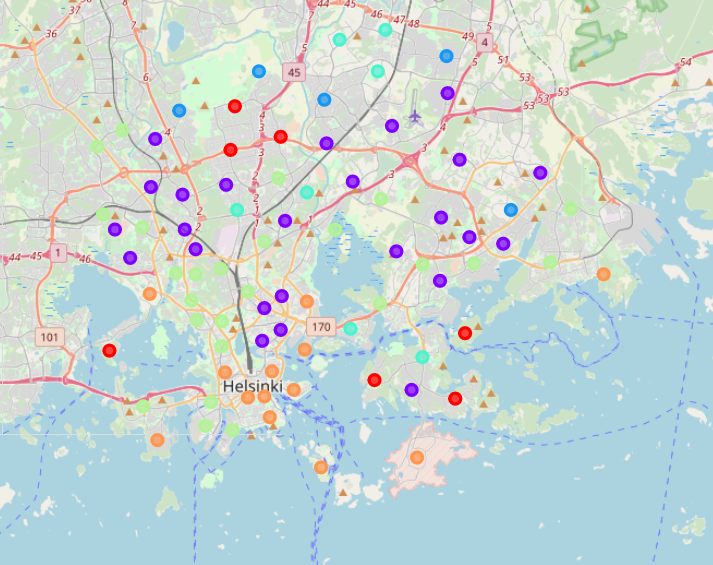

In [85]:
# Examine cluster 0
helsinki_merged.loc[helsinki_merged['Cluster Labels'] == 0]

NeighbourhoodName  EmployedR  UnemployedR    ChildR  StudentR  \
PostalCode                                                                      
00340       Kuusisaari-Lehtisaari   0.437727     0.037485  0.162636  0.083434   
00590                  Kaitalahti   0.452632     0.050000  0.205263  0.086842   
00660                Länsi-Pakila   0.433841     0.034349  0.182497  0.076912   
00670                   Paloheinä   0.475312     0.031920  0.211804  0.070657   
00680                  Itä-Pakila   0.448626     0.041209  0.198077  0.087912   
00830                   Tammisalo   0.412417     0.030155  0.188470  0.068736   
00850                      Jollas   0.459442     0.041680  0.222187  0.080795   

             OthersR  PensionerR  MedianHouseholdIncomeNorm  \
PostalCode                                                    
00340       0.056227    0.222491                   2.616059   
00590       0.042105    0.163158                   2.385119   
00660       0.025687    0.246714                   1.973572   
00670       0.022610    0.187697                   2.389909   
00680       0.029945    0.194231                   1.781906   
00830       0.050998    0.249224                   2.121698   
00850       0.035268    0.160628                   1.991598   

            AverageFloorSizeR  DwellingsHouseR  DwellingsApartmentR  \
PostalCode                                                            
00340                0.757557         0.466121             0.533879   
00590                0.485503         0.414248             0.585752   
00660                0.605799         0.924791             0.075209   
00670                0.619371         0.992007             0.007993   
00680                0.613202         0.886744             0.113256   
00830                0.683529         0.815446             0.184554   
00850                0.638495         0.806626             0.193374   

             Latitude  Longitude  ATM  American Restaurant  Antique Shop  \
PostalCode                                                                 
00340       60.178646  24.852444  0.0                  0.0           0.0   
00590       60.169624  25.019001  0.0                  0.0           0.0   
00660       60.241600  24.928696  0.0                  0.0           0.0   
00670       60.255257  24.931185  0.0                  0.0           0.0   
00680       60.245651  24.960327  0.0                  0.0           0.0   
00830       60.184181  25.076471  0.0                  0.0           0.0   
00850       60.163857  25.069990  0.0                  0.0           0.0   

            Art Gallery  Art Museum  Arts & Crafts Store  Asian Restaurant  \
PostalCode                                                                   
00340               0.0         0.0                  0.0               0.0   
00590               0.0         0.0                  0.0               0.0   
00660               0.0         0.0                  0.0               0.0   
00670               0.0         0.0                  0.0               0.0   
00680               0.0         0.0                  0.0               0.0   
00830               0.0         0.0                  0.0               0.0   
00850               0.0         0.0                  0.0               0.0   

            Auditorium  Auto Workshop  Automotive Shop  BBQ Joint  \
PostalCode                                                          
00340              0.0            0.0              0.0        0.0   
00590              0.0            0.0              0.0        0.0   
00660              0.0            0.0              0.0        0.0   
00670              0.0            0.0              0.0        0.0   
00680              0.0            0.0              0.0        0.0   
00830              0.0            0.0              0.0        0.0   
00850              0.0            0.0              0.0        0.0   

            Badminton Court  Bagel Shop  Bakery  Bar  Basketball Cou

In [86]:
# Examine cluster 1
helsinki_merged.loc[helsinki_merged['Cluster Labels'] == 1]

NeighbourhoodName  EmployedR  UnemployedR    ChildR  \
PostalCode                                                             
00310                     Kivihaka   0.529018     0.061384  0.108259   
00320                  Etelä-Haaga   0.547399     0.052437  0.104051   
00350       Munkkivuori-Niemenmäki   0.501020     0.052281  0.136983   
00360                     Pajamäki   0.501867     0.066667  0.112000   
00400                Pohjois-Haaga   0.453545     0.064762  0.113545   
00420                   Kannelmäki   0.434278     0.074194  0.127046   
00440                      Lassila   0.433415     0.054066  0.113228   
00500                    Sörnäinen   0.619195     0.098431  0.044619   
00510        Etu-Vallila - Alppila   0.589441     0.095456  0.061372   
00530                       Kallio   0.568558     0.078176  0.050849   
00550                      Vallila   0.562660     0.074829  0.077498   
00600             Koskela-Helsinki   0.361893     0.055583  0.129854   
00630              Maunula-Suursuo   0.418243     0.075069  0.142427   
00700                        Malmi   0.431618     0.083485  0.151032   
00710                  Pihlajamäki   0.427244     0.084215  0.151442   
00720             Pukinmäki-Savela   0.441548     0.068038  0.139818   
00770         Jakomäki - Alppikylä   0.404489     0.085869  0.170684   
00800            Länsi-Herttoniemi   0.460483     0.086661  0.133943   
00820                   Roihuvuori   0.434603     0.088300  0.138245   
00870              Etelä-Laajasalo   0.407293     0.071899  0.180058   
00900                  Puotinharju   0.391536     0.097944  0.118259   
00910                      Puotila   0.424009     0.077997  0.137217   
00920                    Myllypuro   0.401103     0.074162  0.166187   
00940             Kontula - Vesala   0.371267     0.091645  0.164543   
00970                   Mellunmäki   0.417286     0.079093  0.144456   

            StudentR   OthersR  PensionerR  MedianHouseholdIncomeNorm  \
PostalCode                                                              
00310       0.068080  0.042411    0.190848                  -0.723080   
00320       0.070327  0.032079    0.193708                  -0.740583   
00350       0.080301  0.036071    0.193344                  -0.575564   
00360       0.078933  0.041600    0.198933                  -0.713066   
00400       0.087090  0.049206    0.231852                  -0.742064   
00420       0.085803  0.054943    0.223736                  -0.775590   
00440       0.074673  0.031908    0.292710                  -0.642791   
00500       0.073625  0.044619    0.119512                  -1.008011   
00510       0.064380  0.040655    0.148697                  -0.971262   
00530       0.067245  0.042169    0.193002                  -0.765140   
00550       0.094257  0.037468    0.153288                  -0.921103   
00600       0.095388  0.048058    0.309223                  -0.896808   
00630       0.065189  0.043017    0.256055                  -0.901597   
00700       0.081740  0.046372    0.205753                  -0.691121   
00710       0.064183  0.048397    0.224519                  -0.656811   
00720       0.081015  0.042319    0.227262                  -0.579657   
00770       0.084513  0.051973    0.202471                  -0.773761   
00800       0.073627  0.041875    0.203411                  -0.839073   
00820       0.076159  0.052980    0.209713                  -0.884007   
00870       0.077050  0.045941    0.217759                  -0.586623   
00900       0.081741  0.059976    0.250544                  -0.917620   
00910       0.073824  0.048307    0.238645                  -0.836112   
00920       0.073916  0.045930    0.238703                  -0.479165   
00940       0.091451  0.057830    0.223264                  -0.775416   
00970       0.077965  0.048998    0.232202                  -0.665084   

            AverageFloorSizeR  DwellingsHouseR  DwellingsApartmentR  \
PostalCode                   

In [87]:
# Examine cluster 2
helsinki_merged.loc[helsinki_merged['Cluster Labels'] == 2]

NeighbourhoodName  EmployedR  UnemployedR    ChildR  \
PostalCode                                                                 
00430                       Maununneva   0.477887     0.037469  0.186732   
00690       Tuomarinkylä-Torpparinmäki   0.459683     0.043197  0.218862   
00760                        Suurmetsä   0.476937     0.040814  0.196942   
00780                    Tapaninvainio   0.452929     0.054608  0.155432   
00950                      Vartioharju   0.472908     0.044946  0.174276   

            StudentR   OthersR  PensionerR  MedianHouseholdIncomeNorm  \
PostalCode                                                              
00430       0.093161  0.026618    0.178133                   1.507164   
00690       0.083153  0.028078    0.167027                   1.237298   
00760       0.081886  0.028893    0.174527                   1.271347   
00780       0.064562  0.030148    0.242321                   0.627554   
00950       0.073548  0.030734    0.203589                   1.081248   

            AverageFloorSizeR  DwellingsHouseR  DwellingsApartmentR  \
PostalCode                                                            
00430                0.550895         0.774852             0.225148   
00690                0.570019         0.832149             0.167851   
00760                0.552128         0.803466             0.196534   
00780                0.504627         0.647023             0.352977   
00950                0.554596         0.755769             0.244231   

             Latitude  Longitude  ATM  American Restaurant  Antique Shop  \
PostalCode                                                                 
00430       60.253826  24.896290  0.0                  0.0           0.0   
00690       60.265903  24.946589  0.0                  0.0           0.0   
00760       60.270866  25.064644  0.0                  0.0           0.0   
00780       60.257305  24.988033  0.0                  0.0           0.0   
00950       60.222775  25.105049  0.0                  0.0           0.0   

            Art Gallery  Art Museum  Arts & Crafts Store  Asian Restaurant  \
PostalCode                                                                   
00430               0.0         0.0                  0.0               0.0   
00690               0.0         0.0                  0.0               0.0   
00760               0.0         0.0                  0.0               0.0   
00780               0.0         0.0                  0.0               0.0   
00950               0.0         0.0                  0.0               0.0   

            Auditorium  Auto Workshop  Automotive Shop  BBQ Joint  \
PostalCode                                                          
00430              0.0            0.0              0.0        0.0   
00690              0.0            0.0              0.0        0.0   
00760              0.0            0.0              0.0        0.0   
00780              0.0            0.0              0.0        0.0   
00950              0.0            0.0              0.0        0.0   

            Badminton Court  Bagel Shop  Bakery  Bar  Basketball Court  Bay  \
PostalCode                                                                    
00430                   0.0         0.0     0.0  0.0               0.0  0.0   
00690                   0.0         0.0     0.0  0.0               0.0  0.0   
00760                   0.0         0.0     0.0  0.0               0.0  0.0   
00780                   0.0         0.0     0.0  0.2               0.0  0.0   
00950                   0.0         0.0     0.0  0.0               0.0  0.0   

            Beach  Beer Bar  Beer Garden  Bike Shop  Bistro  Boat or Ferry  \
PostalCode                                                                   
00430         0.0       0.0          0.0        0.0     0.0            0.0   
00690         0.0       0.0          0.0        0.0     0.0            0.0   
00760         0.0       0.0          0.0        

In [88]:
# Examine cluster 3
helsinki_merged.loc[helsinki_merged['Cluster Labels'] == 3]

NeighbourhoodName  EmployedR  UnemployedR    ChildR  \
PostalCode                                                              
00570                     Kulosaari   0.456851     0.040272  0.152458   
00620       Metsälä-Etelä-Oulunkylä   0.469312     0.042467  0.132052   
00650                    Veräjämäki   0.453395     0.066283  0.188493   
00730                      Tapanila   0.489783     0.056701  0.184962   
00740                     Siltamäki   0.442310     0.054406  0.178316   
00750                      Puistola   0.455799     0.075261  0.175608   
00840                     Laajasalo   0.425452     0.048854  0.153559   

            StudentR   OthersR  PensionerR  MedianHouseholdIncomeNorm  \
PostalCode                                                              
00570       0.081067  0.049948    0.219404                   0.404538   
00620       0.065716  0.022629    0.267824                   0.168808   
00650       0.082394  0.039586    0.169850                   0.031916   
00730       0.075630  0.034056    0.158868                   0.297079   
00740       0.089305  0.031468    0.204196                   0.116298   
00750       0.085686  0.042246    0.165400                  -0.187442   
00840       0.067551  0.028468    0.276116                   0.098882   

            AverageFloorSizeR  DwellingsHouseR  DwellingsApartmentR  \
PostalCode                                                            
00570                0.552128         0.276077             0.723923   
00620                0.491055         0.331226             0.668774   
00650                0.462060         0.260829             0.739171   
00730                0.467613         0.488428             0.511572   
00740                0.481801         0.502361             0.497639   
00750                0.450339         0.421758             0.578242   
00840                0.466996         0.325902             0.674098   

             Latitude  Longitude  ATM  American Restaurant  Antique Shop  \
PostalCode                                                                 
00570       60.185478  25.003901  0.0                  0.0           0.0   
00620       60.222794  24.933062  0.0                  0.0           0.0   
00650       60.228333  24.976429  0.0                  0.0           0.0   
00730       60.265949  25.021076  0.1                  0.0           0.0   
00740       60.275795  24.997026  0.0                  0.0           0.0   
00750       60.279026  25.026157  0.0                  0.0           0.0   
00840       60.176624  25.049763  0.0                  0.0           0.0   

            Art Gallery  Art Museum  Arts & Crafts Store  Asian Restaurant  \
PostalCode                                                                   
00570               0.0         0.0                  0.0               0.0   
00620               0.0         0.0                  0.0               0.0   
00650               0.0         0.0                  0.0               0.0   
00730               0.0         0.0                  0.0               0.0   
00740               0.0         0.0                  0.0               0.0   
00750               0.0         0.0                  0.0               0.0   
00840               0.0         0.0                  0.0               0.0   

            Auditorium  Auto Workshop  Automotive Shop  BBQ Joint  \
PostalCode                                                          
00570              0.0            0.0              0.0        0.0   
00620              0.0            0.0              0.0        0.0   
00650              0.0            0.0              0.0        0.0   
00730              0.0            0.0              0.0        0.0   
00740              0.0            0.0              0.0        0.0   
00750              0.0            0.0              0.0        0.0   
00840              0.0            0.0              0.0        0.0   

            Badminton Court  Bagel Shop  Bakery  Bar

In [89]:
# Examine cluster 4
helsinki_merged.loc[helsinki_merged['Cluster Labels'] == 4]

NeighbourhoodName  EmployedR  UnemployedR    ChildR  \
PostalCode                                                                 
00150                Eira - Hernesaari   0.569631     0.057641  0.098075   
00180              Kamppi - Ruoholahti   0.554610     0.058448  0.115832   
00200                      Lauttasaari   0.531131     0.046177  0.137323   
00220                       Jätkäsaari   0.568197     0.048321  0.152502   
00240                     Länsi-Pasila   0.482094     0.061892  0.111717   
00250                       Taka-Töölö   0.583807     0.051449  0.090441   
00260                      Keski-Töölö   0.504795     0.046846  0.088528   
00270                 Pohjois-Meilahti   0.536107     0.062925  0.125850   
00280                        Ruskeasuo   0.530667     0.049000  0.110333   
00290          Meilahden sairaala-alue   0.546584     0.049689  0.105590   
00300                 Pikku Huopalahti   0.445450     0.069319  0.168516   
00370                         Reimarla   0.449640     0.059952  0.170114   
00380       Pitäjänmäen teollisuusalue   0.479339     0.073691  0.150138   
00390                           Konala   0.502897     0.067267  0.148214   
00410                    Malminkartano   0.476130     0.075463  0.155758   
00520                       Itä-Pasila   0.494909     0.075434  0.108848   
00560            Toukola-Vanhakaupunki   0.532949     0.049670  0.165997   
00610                           Käpylä   0.475796     0.060237  0.156079   
00640                 Oulunkylä-Patola   0.464157     0.050068  0.144366   
00790                           Viikki   0.486023     0.051481  0.218378   
00810                      Herttoniemi   0.491586     0.076816  0.164705   
00880       Roihupellon teollisuusalue   0.499308     0.066390  0.105118   
00930             Itäkeskus-Marjaniemi   0.394319     0.071534  0.152929   
00960                 Pohjois-Vuosaari   0.442079     0.072021  0.151645   
00980                   Etelä-Vuosaari   0.382682     0.089819  0.185434   

            StudentR   OthersR  PensionerR  MedianHouseholdIncomeNorm  \
PostalCode                                                              
00150       0.060652  0.054414    0.159587                  -0.284276   
00180       0.065212  0.050467    0.155431                  -0.104366   
00200       0.061256  0.035587    0.188526                  -0.095658   
00220       0.120631  0.033585    0.076765                  -0.032263   
00240       0.076294  0.036785    0.231218                  -0.286889   
00250       0.066522  0.036285    0.171496                  -0.393651   
00260       0.057174  0.050350    0.252305                  -0.052640   
00270       0.072344  0.034668    0.168106                  -0.536464   
00280       0.104333  0.027333    0.178333                  -0.509382   
00290       0.024845  0.080745    0.192547                  -0.214350   
00300       0.080417  0.036537    0.199761                  -0.193450   
00370       0.081385  0.045713    0.193195                  -0.214263   
00380       0.080119  0.039486    0.177227                  -0.306308   
00390       0.067589  0.036852    0.177181                  -0.330952   
00410       0.109513  0.045669    0.137467                  -0.463490   
00520       0.074573  0.056647    0.189588                  -0.562763   
00560       0.092440  0.028589    0.130356                  -0.099838   
00610       0.063041  0.033411    0.211438                  -0.423433   
00640       0.076407  0.032799    0.232203                  -0.307353   
00790       0.114678  0.036996    0.092444                  -0.302651   
00810       0.074113  0.038626    0.154155                  -0.289937   
00880       0.069156  0.041494    0.218534                  -0.513039   
00930       0.092140  0.055637    0.233441                  -0.482126   
00960       0.069671  0.038291    0.226293                  -0.533329   
00980       0.086855  0.054245    0.200965                  -0.577480 

In [90]:
# Examine cluster 5
helsinki_merged.loc[helsinki_merged['Cluster Labels'] == 5]

NeighbourhoodName  EmployedR  UnemployedR    ChildR  \
PostalCode                                                                    
00100       Helsinki Keskusta - Etu-Töölö   0.552440     0.048355  0.099228   
00120                           Punavuori   0.546114     0.049815  0.113009   
00130                     Kaartinkaupunki   0.561198     0.045573  0.110677   
00140            Kaivopuisto - Ullanlinna   0.525905     0.048996  0.114110   
00160                         Katajanokka   0.461521     0.044519  0.138926   
00170                         Kruununhaka   0.556894     0.041943  0.117440   
00190                         Suomenlinna   0.477273     0.056818  0.236111   
00210                          Vattuniemi   0.499156     0.037937  0.152007   
00330                         Munkkiniemi   0.454535     0.039486  0.140569   
00540                          Kalasatama   0.568480     0.041276  0.121951   
00580                         Verkkosaari   0.534730     0.036016  0.158030   
00860                         Santahamina   0.590588     0.018824  0.301176   
00990                        Aurinkolahti   0.478641     0.056583  0.161004   

            StudentR   OthersR  PensionerR  MedianHouseholdIncomeNorm  \
PostalCode                                                              
00100       0.070405  0.045165    0.184408                   0.135282   
00120       0.061771  0.051950    0.177341                   0.311709   
00130       0.072266  0.046224    0.164062                   0.701486   
00140       0.064987  0.054880    0.191122                   0.397746   
00160       0.062416  0.044966    0.247651                   0.530197   
00170       0.068597  0.041402    0.173725                   0.371360   
00190       0.068182  0.046717    0.114899                   0.537337   
00210       0.045862  0.030401    0.234637                   0.785519   
00330       0.069495  0.040050    0.255866                   0.096357   
00540       0.107411  0.021576    0.139306                   0.189447   
00580       0.079383  0.042264    0.149577                   0.059521   
00860       0.054118  0.021176    0.014118                   1.046938   
00990       0.053710  0.041844    0.208219                   0.085820   

            AverageFloorSizeR  DwellingsHouseR  DwellingsApartmentR  \
PostalCode                                                            
00100                0.408390         0.000170             0.999830   
00120                0.426897         0.001583             0.998417   
00130                0.462060         0.000000             1.000000   
00140                0.455891         0.002580             0.997420   
00160                0.472548         0.000749             0.999251   
00170                0.419494         0.001961             0.998039   
00190                0.434917         0.211679             0.788321   
00210                0.438001         0.008968             0.991032   
00330                0.433066         0.044927             0.955073   
00540                0.383097         0.015886             0.984114   
00580                0.375077         0.008469             0.991531   
00860                0.380629         0.148000             0.852000   
00990                0.409007         0.047514             0.952486   

             Latitude  Longitude  ATM  American Restaurant  Antique Shop  \
PostalCode                                                                 
00100       60.172020  24.925289  0.0             0.000000      0.000000   
00120       60.164116  24.939407  0.0             0.010000      0.000000   
00130       60.164246  24.949619  0.0             0.010989      0.010989   
00140       60.157925  24.953203  0.0             0.000000      0.020000   
00160       60.166576  24.968697  0.0             0.000000      0.000000   
00170       60.172165  24.955093  0.0             0.000000      0.000000   
00190       60.142090  24.985359  0.0             0.000000      0.00

In [115]:
helsinki_data.corr()

EmployedR  UnemployedR    ChildR  StudentR  \
EmployedR                         1.000000    -0.246359 -0.405733 -0.208461   
UnemployedR                      -0.246359     1.000000 -0.360091  0.114670   
ChildR                           -0.405733    -0.360091  1.000000  0.182867   
StudentR                         -0.208461     0.114670  0.182867  1.000000   
OthersR                          -0.205343     0.450477 -0.308608 -0.201543   
PensionerR                       -0.652993     0.113408 -0.252621 -0.215605   
MedianHouseholdIncomeNorm        -0.021108    -0.732189  0.560558 -0.041624   
AverageFloorSizeR                -0.389472    -0.565060  0.586388  0.046404   
DwellingsHouseR                  -0.336947    -0.409933  0.594327  0.117908   
DwellingsApartmentR               0.336947     0.409933 -0.594327 -0.117908   
Latitude                         -0.468928     0.233346  0.203626  0.312951   
Longitude                        -0.395068     0.252056  0.328543  0.029919   
ATM                               0.017665    -0.017288  0.101494 -0.005605   
American Restaurant               0.202948    -0.106874 -0.131940 -0.099488   
Antique Shop                      0.153448    -0.101009 -0.122709 -0.092369   
Art Gallery                       0.228835    -0.133253 -0.107195  0.201684   
Art Museum                        0.043027    -0.159701 -0.086162 -0.072610   
Arts & Crafts Store               0.127396    -0.061068 -0.089582 -0.112288   
Asian Restaurant                  0.211668    -0.130112 -0.151847 -0.206736   
Auditorium                       -0.037388    -0.094740 -0.020757 -0.107319   
Auto Workshop                     0.110303    -0.044929  0.050225  0.099108   
Automotive Shop                   0.043209     0.049898  0.003906 -0.067499   
BBQ Joint                         0.120956    -0.155679  0.018204  0.008622   
Badminton Court                  -0.046485    -0.121744  0.015177  0.036244   
Bagel Shop                        0.127396    -0.061068 -0.089582 -0.112288   
Bakery                            0.220141     0.000035 -0.178978 -0.180011   
Bar                               0.173027     0.088419 -0.299359 -0.132167   
Basketball Court                  0.046908    -0.079944 -0.154591 -0.147666   
Bay                               0.021177     0.110607  0.047699 -0.017285   
Beach                            -0.094736    -0.034608  0.233769 -0.031585   
Beer Bar                          0.257955     0.243673 -0.356238 -0.236253   
Beer Garden                       0.201908     0.080416 -0.046195 -0.157324   
Bike Shop                        -0.190964     0.193284  0.102747  0.080793   
Bistro                            0.326888    -0.019328 -0.239689  0.194384   
Boat or Ferry                     0.085006    -0.126737  0.079814 -0.123712   
Bookstore                         0.103974     0.145288 -0.243089  0.057411   
Boutique                          0.156778    -0.088039 -0.095774 -0.031503   
Bowling Alley                     0.046908    -0.079944 -0.154591 -0.147666   
Brazilian Restaurant              0.105219    -0.148803  0.029974  0.023279   
Breakfast Spot                    0.231339     0.000373 -0.181798 -0.118711   
Brewery                           0.246961    -0.154479 -0.145700 -0.096812   
Bridge                           -0.004040    -0.018038  0.037872 -0.174336   
Buffet                           -0.002680     0.090743  0.009015  0.028950   
Burger Joint                      0.191881     0.379701 -0.327687 -0.079066   
Burrito Place                     0.159626     0.097977 -0.183882  0.137773   
Bus Line                          0.020356    -0.002354 -0.027654  0.175439   
Bus Stop                         -0.387287     0.032681  0.289936  0.231027   
Cafeteria                        -0.069816     0.038975 -0.096187 -0.021196   
Café                              0.211178    -0.112859 -0.183921 -0.120371   
Campground                       -0.190964     0.193284  0.102747  0.080793   
Cana